## Loan Default Prediction Model Development 
### This notebook demonstrates an OOP-based approach to:
 - Load and explore the loan default dataset
 - Perform Exploratory Data Analysis (EDA)
 - Prepare training and testing data
 - Train multiple classification models (Logistic Regression, Random Forest, and XGBoost)
 - Evaluate models using Accuracy, F1-score, and AUC-ROC
 - Select and save the best-performing model

In [27]:
# Data handling and computation
import numpy as np
import pandas as pd
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model evaluation and metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Data splitting and validation
from sklearn.model_selection import train_test_split, StratifiedKFold

# System and warnings
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Define a class to build and evaluate loan default models
class LoanModelBuilder:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.data = None
        self.X_train = self.X_test = self.y_train = self.y_test = None
        self.models = {}
        self.results = {}
    
    def load_data(self):
        """
        Load the loan default dataset from a CSV file.
        Expected columns: customer_id, age, income, loan_amount, credit_score, loan_status.
        """
        self.data = pd.read_csv(self.filepath)
        # Ensure proper data types
        self.data['age'] = pd.to_numeric(self.data['age'], errors='coerce')
        self.data['income'] = pd.to_numeric(self.data['income'], errors='coerce')
        self.data['loan_amount'] = pd.to_numeric(self.data['loan_amount'], errors='coerce')
        self.data['credit_score'] = pd.to_numeric(self.data['credit_score'], errors='coerce')
        self.data['loan_status'] = pd.to_numeric(self.data['loan_status'], errors='coerce')
        print("Loan data loaded successfully!")
        return self.data

    def perform_eda(self):
        """
        Perform basic exploratory data analysis (EDA):
        - Print summary statistics
        - Plot pairplots and correlation heatmap
        """
        print("Data Description:")
        print(self.data.describe())
        
        # Pairplot to visualize relationships
        sns.pairplot(self.data.drop(columns=['customer_id']))
        plt.show()
        
        # Correlation heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.data.drop(columns=['customer_id']).corr(), annot=True, cmap='coolwarm')
        plt.title("Feature Correlation")
        plt.show()

    def prepare_data(self):
        """
        Prepare the training and testing datasets.
        Excludes 'customer_id' and uses 'loan_status' as target.
        Uses stratification if the test set size is large enough to include at least one sample for each class.
        """
        features = self.data.drop(['customer_id', 'loan_status'], axis=1)
        target = self.data['loan_status']
        n_samples = len(self.data)
        test_size = 0.2
        n_test = int(np.ceil(n_samples * test_size))
        n_classes = len(np.unique(target))
        
        if n_test < n_classes:
            print("Warning: Test set size too small for stratification. Using random split instead.")
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                features, target, test_size=test_size, random_state=42
            )
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                features, target, test_size=test_size, random_state=42, stratify=target
            )
        print("Data split into training and testing sets.")
        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_logistic_regression(self):
        """
        Train a Logistic Regression model and store it.
        """
        model = LogisticRegression(max_iter=1000)
        model.fit(self.X_train, self.y_train)
        self.models['LogisticRegression'] = model
        print("Logistic Regression model trained.")

    def train_random_forest(self):
        """
        Train a Random Forest Classifier and store it.
        """
        model = RandomForestClassifier(random_state=42)
        model.fit(self.X_train, self.y_train)
        self.models['RandomForest'] = model
        print("Random Forest model trained.")

    def train_xgboost(self):
        """
        Train an XGBoost Classifier and store it.
        """
        model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
        model.fit(self.X_train, self.y_train)
        self.models['XGBoost'] = model
        print("XGBoost model trained.")

    def cross_validate_models(self, cv=2):
        """
        Evaluate each trained model using stratified k-fold cross-validation with 2 splits.
        Aggregates Accuracy, F1-score, and AUC-ROC across folds.
        """
        features = self.data.drop(['customer_id', 'loan_status'], axis=1)
        target = self.data['loan_status']
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        for name, model in self.models.items():
            accuracies = []
            f1_scores = []
            auc_scores = []
            fold = 1
            for train_index, test_index in skf.split(features, target):
                X_train_cv = features.iloc[train_index]
                y_train_cv = target.iloc[train_index]
                X_test_cv = features.iloc[test_index]
                y_test_cv = target.iloc[test_index]
                
                model.fit(X_train_cv, y_train_cv)
                y_pred_cv = model.predict(X_test_cv)
                try:
                    y_proba_cv = model.predict_proba(X_test_cv)[:, 1]
                except Exception:
                    y_proba_cv = np.zeros(len(y_pred_cv))
                    
                acc = accuracy_score(y_test_cv, y_pred_cv)
                f1 = f1_score(y_test_cv, y_pred_cv, zero_division=1)
                if len(np.unique(y_test_cv)) == 1:
                    print(f"Warning: Only one class present in fold {fold} for {name}. ROC AUC cannot be computed.")
                    auc = 0.0
                else:
                    auc = roc_auc_score(y_test_cv, y_proba_cv)
                accuracies.append(acc)
                f1_scores.append(f1)
                auc_scores.append(auc)
                fold += 1

            self.results[name] = {
                'accuracy': np.mean(accuracies),
                'f1_score': np.mean(f1_scores),
                'auc_roc': np.mean(auc_scores)
            }
            print(f"{name} - CV Accuracy: {self.results[name]['accuracy']:.3f}, "
                  f"CV F1-Score: {self.results[name]['f1_score']:.3f}, "
                  f"CV AUC-ROC: {self.results[name]['auc_roc']:.3f}")

    def evaluate_models(self):
        """
        Evaluate each trained model using the test set.
        If the test set is not representative (only one class present), switch to cross-validation.
        """
        if len(np.unique(self.y_test)) == 1:
            print("Test set is not representative. Switching to cross-validation evaluation.")
            self.cross_validate_models(cv=3)
        else:
            for name, model in self.models.items():
                y_pred = model.predict(self.X_test)
                try:
                    y_proba = model.predict_proba(self.X_test)[:, 1]
                except Exception:
                    y_proba = np.zeros(len(y_pred))
                acc = accuracy_score(self.y_test, y_pred)
                f1 = f1_score(self.y_test, y_pred)
                auc = roc_auc_score(self.y_test, y_proba)
                self.results[name] = {'accuracy': acc, 'f1_score': f1, 'auc_roc': auc}
                print(f"{name} - Accuracy: {acc:.3f}, F1-Score: {f1:.3f}, AUC-ROC: {auc:.3f}")

    def select_best_model(self):
        """
        Select the best model based on the highest AUC-ROC.
        """
        best_model_name = max(self.results, key=lambda k: self.results[k]['auc_roc'])
        print("Best model selected:", best_model_name)
        return self.models[best_model_name]

    def save_model(self, model, filename: str):
        """
        Save the selected best model to disk.
        """
        joblib.dump(model, filename)
        print("Model saved as", filename)


Loan data loaded successfully!
Data Description:
       customer_id        age        income  loan_amount  credit_score  \
count     5.000000   5.000000      5.000000      5.00000      5.000000   
mean    103.000000  35.600000  63600.000000  20000.00000    712.000000   
std       1.581139   9.813256  12300.406497   7382.41153     55.407581   
min     101.000000  25.000000  50000.000000  12000.00000    640.000000   
25%     102.000000  29.000000  55000.000000  15000.00000    680.000000   
50%     103.000000  34.000000  61000.000000  18000.00000    710.000000   
75%     104.000000  40.000000  72000.000000  25000.00000    750.000000   
max     105.000000  50.000000  80000.000000  30000.00000    780.000000   

       loan_status  
count     5.000000  
mean      0.400000  
std       0.547723  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  


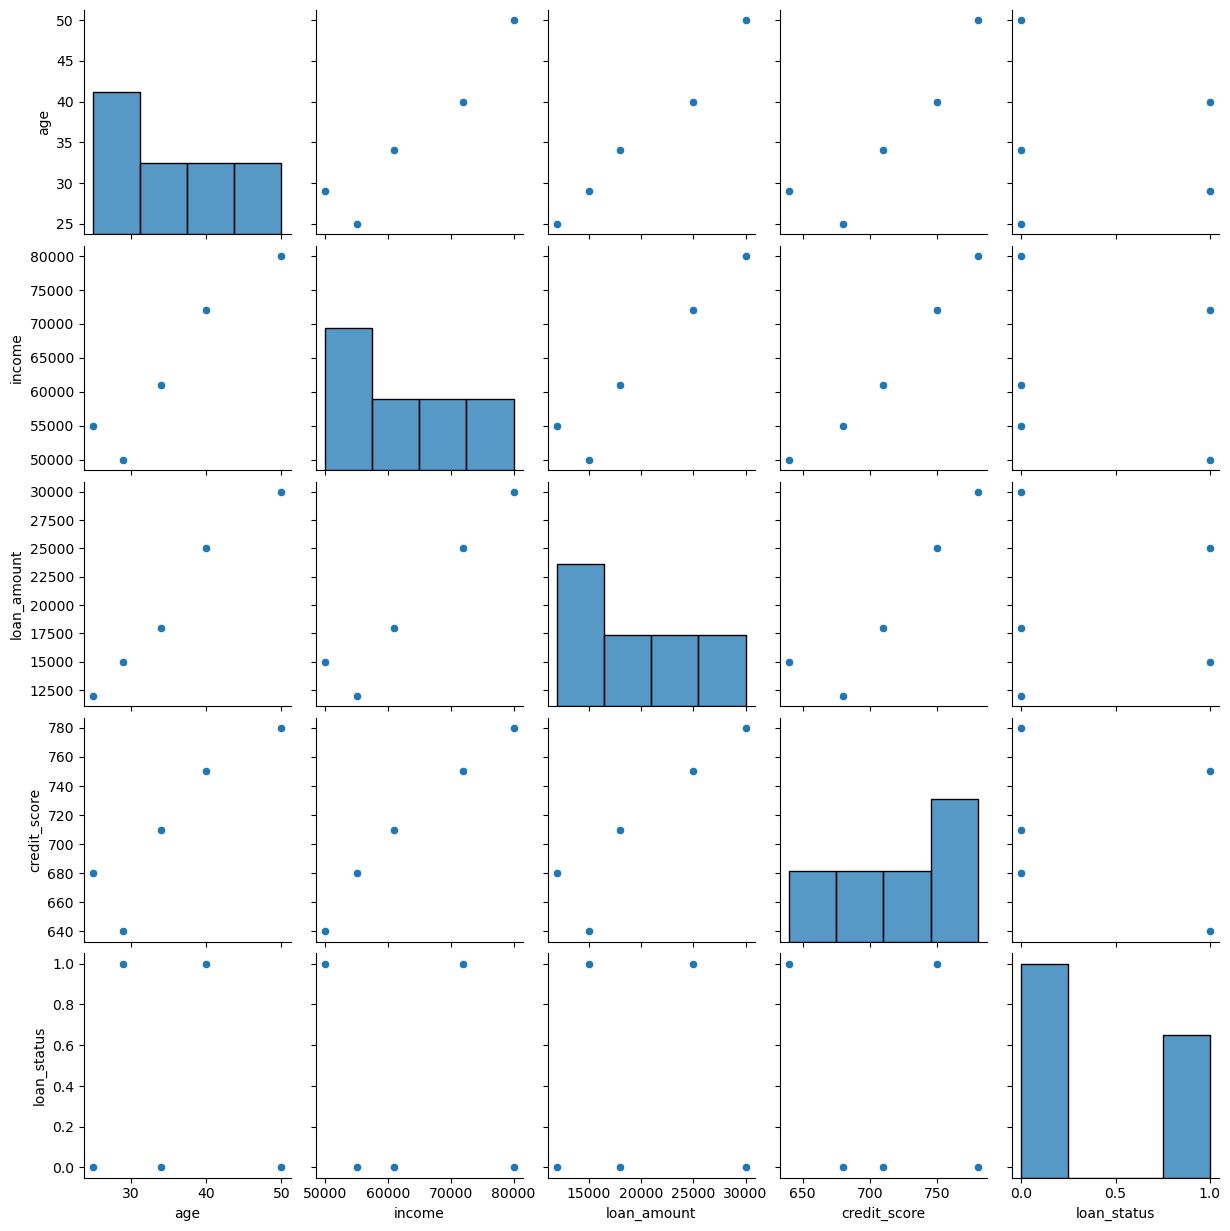

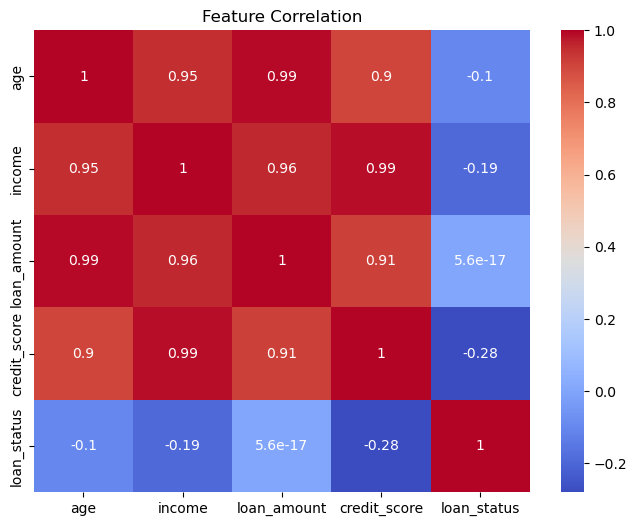

Data split into training and testing sets.
Logistic Regression model trained.
Random Forest model trained.
XGBoost model trained.
Test set is not representative. Switching to cross-validation evaluation.
LogisticRegression - CV Accuracy: 0.500, CV F1-Score: 0.333, CV AUC-ROC: 0.333
RandomForest - CV Accuracy: 0.333, CV F1-Score: 0.000, CV AUC-ROC: 0.167
XGBoost - CV Accuracy: 0.667, CV F1-Score: 0.333, CV AUC-ROC: 0.333
Best model selected: LogisticRegression
Model saved as ../models/loan_model.pkl


In [29]:
# Usage
if __name__ == '__main__':
    # Instantiate the LoanModelBuilder with the dataset path
    builder = LoanModelBuilder('../data/loan_default_data.csv')
    builder.load_data()
    builder.perform_eda()
    builder.prepare_data()
    
    # Train models
    builder.train_logistic_regression()
    builder.train_random_forest()
    builder.train_xgboost()
    
    # Evaluate models
    builder.evaluate_models()
    
    # Select and save the best-performing model
    best_model = builder.select_best_model()
    builder.save_model(best_model, '../models/loan_model.pkl')


### **Deployed Link: https://loan-api-app-ezgtdtdbekh5eghw.southafricanorth-01.azurewebsites.net/**